# Embeddings - Ejercicio Simple de RAG

In [1]:
import numpy as np
import pandas as pd
from docling.document_converter import DocumentConverter
from dotenv import load_dotenv

from IPython.display import Markdown, display
from gensim.models import Word2Vec


load_dotenv(".env")

True

## Extracción de Texto PDF

In [2]:
source = "proyect_final.pdf"  # PDF path or URL
converter = DocumentConverter()
result = converter.convert(source)
print(result.document.export_to_markdown())

/Users/miguelarquezabi/dsrp-jul30/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/miguelarquezabi/dsrp-jul30/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


<!-- image -->

## Proyecto Curso II -Especialización Machine Learning Engineering

El proyecto del curso II de la especialización de Machine Learning Engineering tiene como objetivo enfrentar al estudiante a:

- -Conocimiento  teórico  de  algoritmos  populares  y  avanzados  de  Machine Learning en la industria
- -Administración de ciclo de vida de modelos de Machine Learning

Fecha máxima de entrega: Domingo 17 de Agosto de 2025

Entregable : Repositorio de GitHub en versión 1.0.0 con las siguientes secciones:

1.  README.md
- a.  Problema de ML
- b.  Diagrama de flujo del proyecto
- c. Descripción del dataset con su respectivo diccionario de datos
- d.  Model Card https://www.kaggle.com/code/var0101/model-cards
- e.  Resultados con Métricas de evaluación offline y online
- f. Conclusiones
2.  Estructura del repositorio de código con:
- a.  Carpeta de notebooks
- i.  Notebook preprocesamiento de datos
- ii.  Notebook de Machine Learning
- b.  Carpeta de datos (.csv, .txt, .parquet)


## Chunking

In [5]:
def fixed_window_splitter(text: str, chunk_size: int = 500) -> list[str]:
    """Splits text at given chunk_size"""
    splits = []
    for i in range(0, len(text), chunk_size):
        splits.append(text[i:i + chunk_size])
    return splits

texts = fixed_window_splitter(result.document.export_to_markdown())
len(texts)

14

# Pregunta RAG: QUESTION = '¿Cuáles son los criterios de evaluación?'

In [4]:
QUESTION = '¿Cuáles son los criterios de evaluación?'

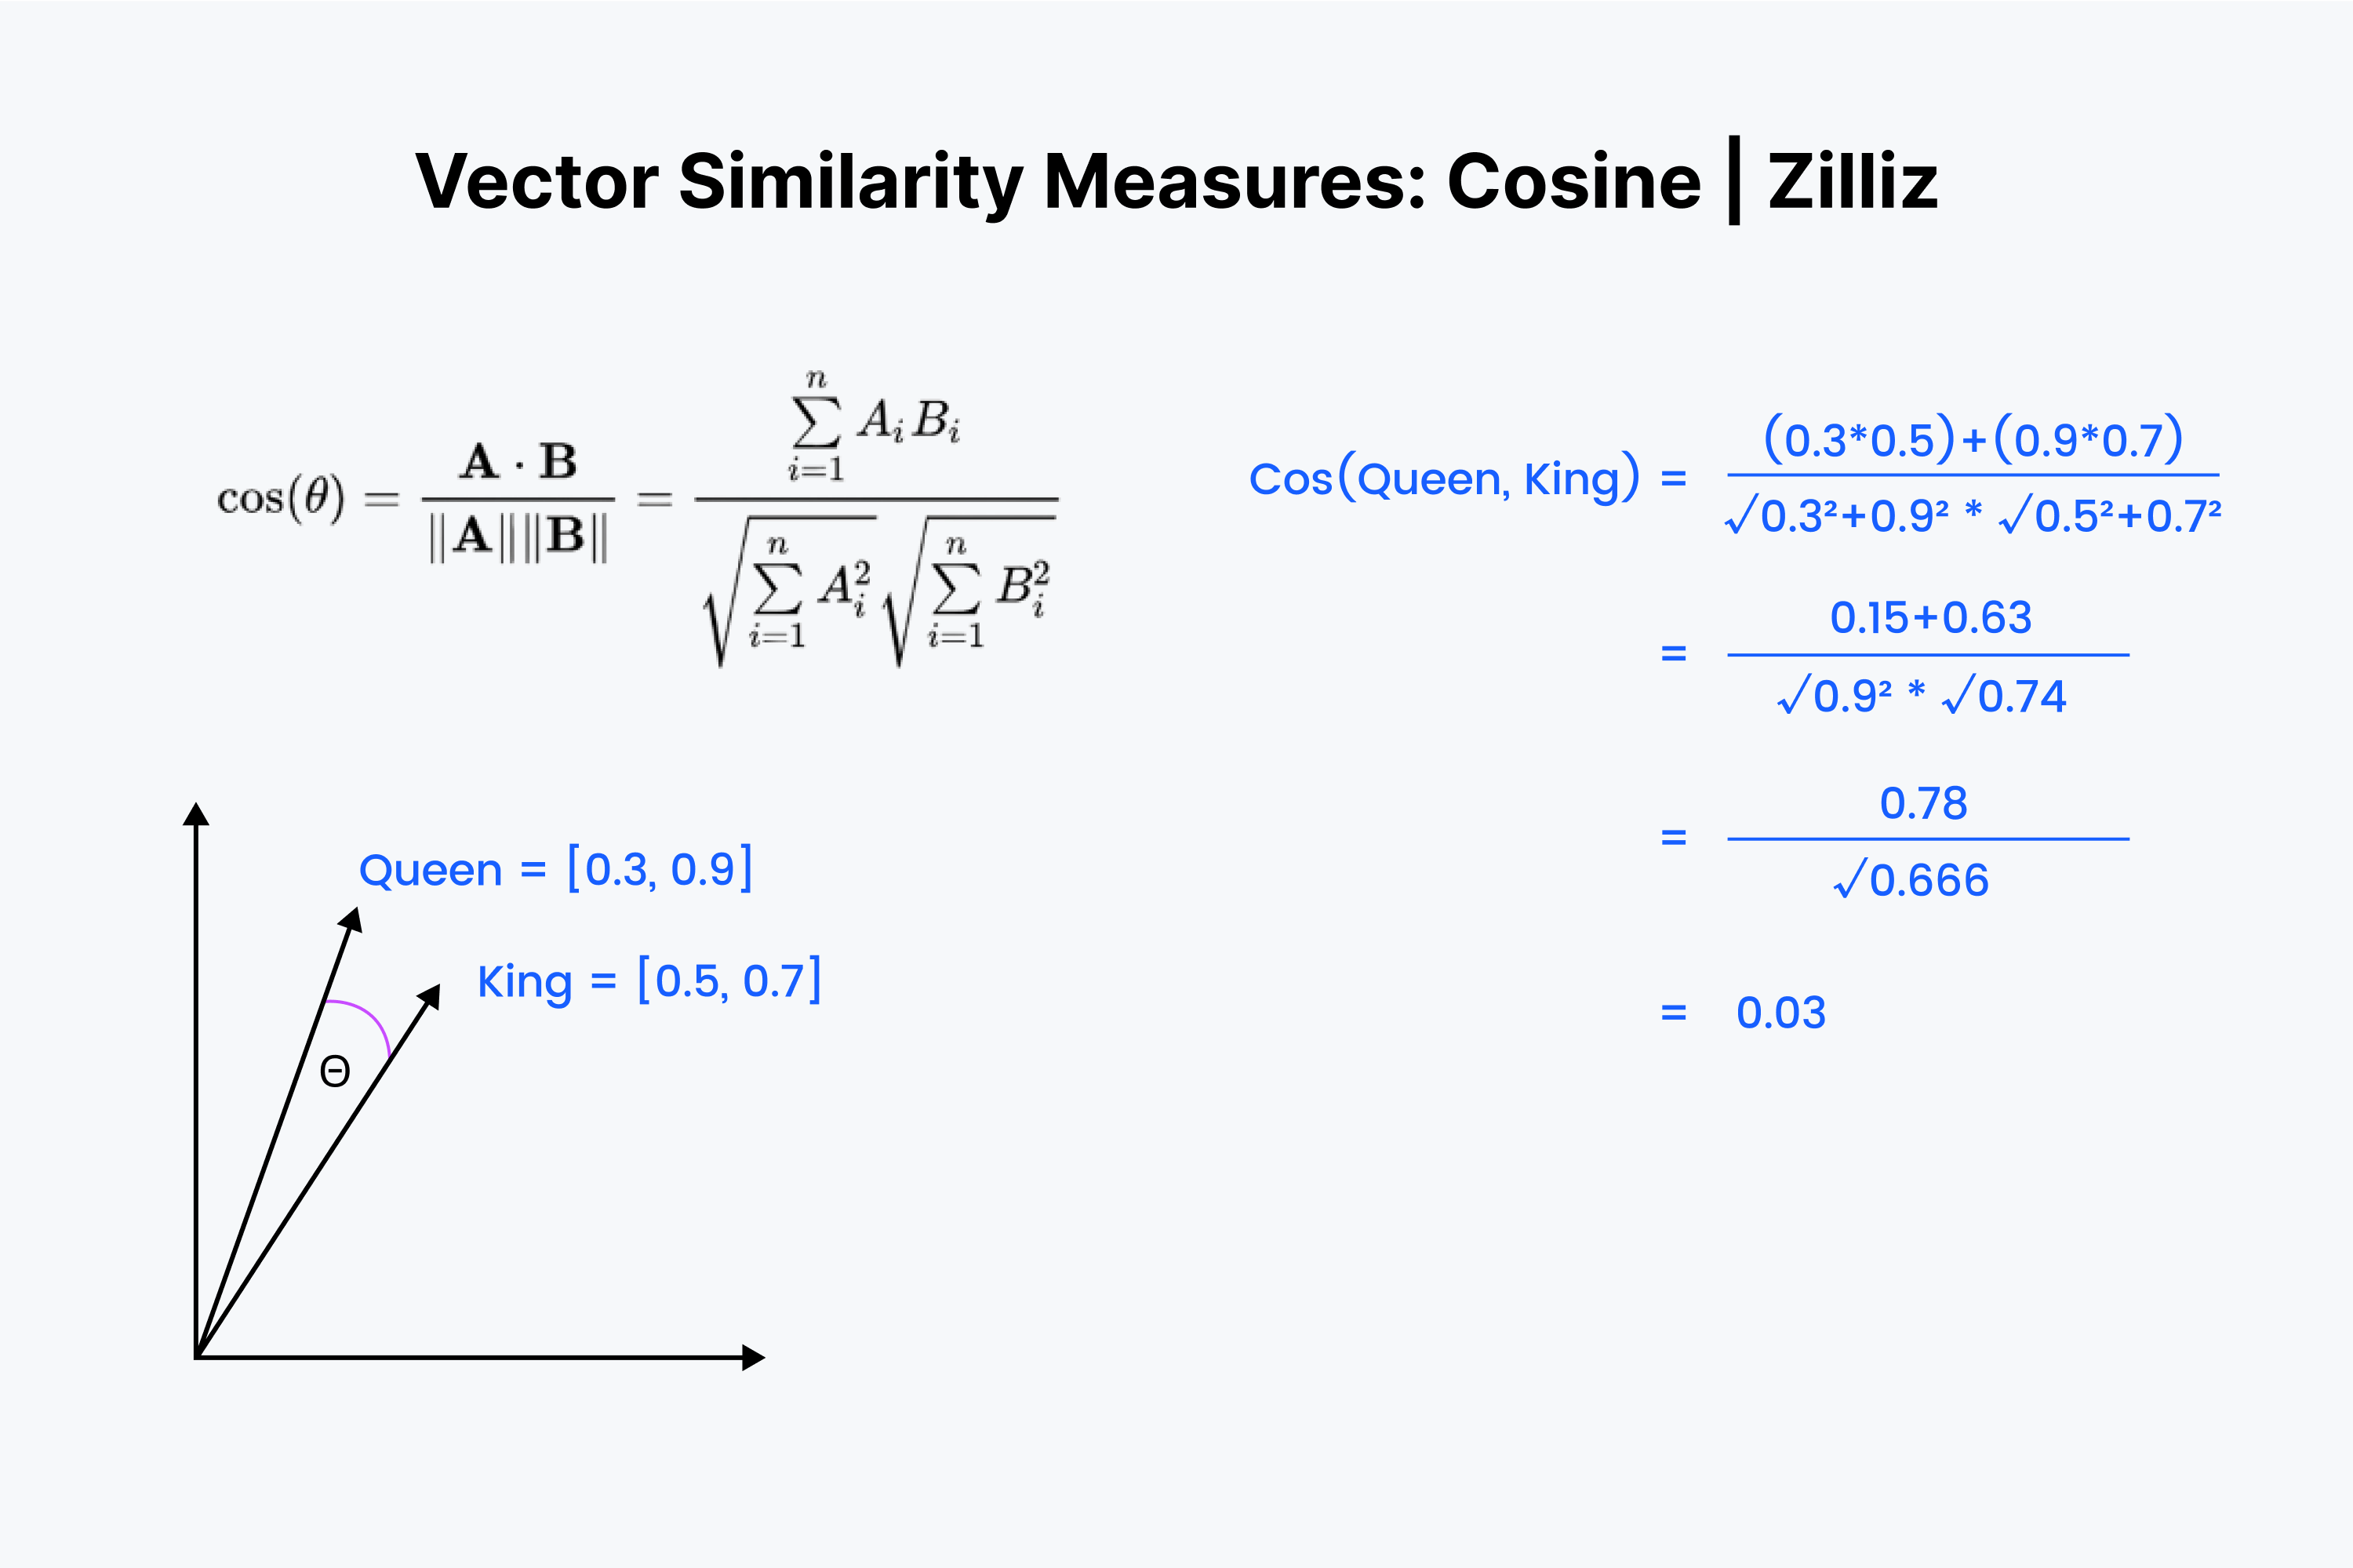

## Word2Vec Embeddings

In [6]:
import nltk
from nltk.tokenize import sent_tokenize
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

# Descargar recursos de NLTK si es la primera vez
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Lista de stopwords en español
stop_words = set(stopwords.words('spanish'))

def preprocess_text_spanish(text):
    # Paso 1: dividir en oraciones
    sentences = sent_tokenize(text, language='spanish')
    
    # Paso 2: tokenizar oraciones y limpiar
    tokenized_sentences = []
    for sentence in sentences:
        tokens = simple_preprocess(sentence, deacc=True)  # deacc=True quita tildes
        filtered = [word for word in tokens if word not in stop_words and len(word) > 2]
        tokenized_sentences.append(filtered)
        
    return tokenized_sentences


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miguelarquezabi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelarquezabi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/miguelarquezabi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [9]:
tokens[0]

['image',
 'proyecto',
 'curso',
 'especializacion',
 'machine',
 'learning',
 'engineering',
 'proyecto',
 'curso',
 'especializacion',
 'machine',
 'learning',
 'engineering',
 'objetivo',
 'enfrentar',
 'estudiante',
 'conocimiento',
 'teorico',
 'algoritmos',
 'populares',
 'avanzados',
 'machine',
 'learning',
 'industria',
 'administracion',
 'ciclo',
 'vida',
 'modelos',
 'machine',
 'learning',
 'fecha',
 'maxima',
 'entrega',
 'domingo',
 'agosto',
 'entregable',
 'repositorio',
 'github',
 'version',
 'siguientes',
 'secciones']

In [14]:
tokens = preprocess_text_spanish(result.document.export_to_markdown())

modelo = Word2Vec(
    tokens,
    vector_size=60,
    window=5,
    min_count=1,
    sg=1
)

In [15]:
modelo.wv["image"]

array([-0.00858953, -0.01055742, -0.01369223,  0.01360186, -0.00316399,
       -0.01148192, -0.00638681,  0.00916542, -0.00480487, -0.00658082,
        0.00347783, -0.00385178, -0.00257023,  0.00132097, -0.00451225,
        0.01400073,  0.00706873, -0.0173477 ,  0.00963352, -0.01176105,
        0.0015599 ,  0.00663377, -0.00815798, -0.00289242,  0.01393139,
       -0.00694069, -0.01284406,  0.01556347, -0.00319063, -0.00805508,
        0.01456085,  0.00618132,  0.00746522,  0.01542347, -0.01337552,
        0.00996706,  0.00327362,  0.00655494,  0.00219946,  0.00752255,
        0.00743544,  0.01061267, -0.00574771, -0.00759107, -0.00061387,
        0.00436249, -0.00564664,  0.01078879,  0.00632668,  0.01345118,
        0.00449421,  0.01399181, -0.00216045,  0.01399596,  0.00673175,
       -0.01278707, -0.00649778, -0.00390495,  0.00905841, -0.00242723],
      dtype=float32)

In [18]:
new_tokens = simple_preprocess(QUESTION, deacc=True)
filtered_tokens = [w for w in new_tokens if w not in stop_words and len(w) > 2]

def sentence_vector(model, sentence_tokens):
    vectors = [model.wv[word] for word in sentence_tokens if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Encode
vec1 = sentence_vector(modelo, filtered_tokens)


similarities = {}
for i in range(len(texts)):
    print(f"Texto {i}")
    text_tokens = [w for w in simple_preprocess(texts[i], deacc=True) if w not in stop_words and len(w) > 2]
    vec2 = sentence_vector(modelo, text_tokens)

    # Compute cosine similarity
    similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    similarities[i] = similarity

    print(f"Similitud: {similarity.item():.4f}")

best_candidates =  [i[0] for i in sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:5]]
word2_vec_context = [texts[i] for i in best_candidates]

Texto 0
Similitud: 0.3432
Texto 1
Similitud: 0.3167
Texto 2
Similitud: 0.1960
Texto 3
Similitud: 0.1848
Texto 4
Similitud: 0.1737
Texto 5
Similitud: 0.4283
Texto 6
Similitud: 0.1985
Texto 7
Similitud: 0.8114
Texto 8
Similitud: 0.1199
Texto 9
Similitud: 0.2175
Texto 10
Similitud: 0.2362
Texto 11
Similitud: 0.0501
Texto 12
Similitud: 0.2685
Texto 13
Similitud: 0.1262


In [25]:
word2_vec_context

['                                                                                                                                                                      | Porcentaje en la evaluación                                  |\n|--------------------------------|-------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 '/\n- -Usar datasets tabulares de  tamaño  no  mayor  a  100MB,  además  se recomienda  no  usar  datos  que  requieran  procesos  de  ingeniería  de  datos complejos, pues esto no será evaluado.\n- -Crear estructura del proyecto con cookiecutter  https://www.cookiecutter.io/\n- -Revisar la guía básica de Markdown para preparar el README.md con mejor estructura. https://markdown.es/\n- -Agregar  excepciones  adicionales  para  archivos  que  estemos  manejando. https://docs.github.com/es/

## Sentence Transformers Embeddings

In [21]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')

In [22]:
embedding1 = model.encode(QUESTION, convert_to_tensor=True)

similarities = {}
for i in range(len(texts)):
    print(f"Texto {i}")
    embedding2 = model.encode(texts[i], convert_to_tensor=True)

    # Compute cosine similarity
    similarity = util.pytorch_cos_sim(embedding1, embedding2)
    similarities[i] = similarity.item()

    print(f"Similitud: {similarity.item():.4f}")

/Users/miguelarquezabi/dsrp-jul30/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Texto 0
Similitud: 0.2064
Texto 1
Similitud: 0.1619
Texto 2
Similitud: 0.1467
Texto 3
Similitud: 0.1592
Texto 4
Similitud: 0.2331
Texto 5
Similitud: 0.0939
Texto 6
Similitud: 0.0966
Texto 7
Similitud: 0.1838
Texto 8
Similitud: 0.1813
Texto 9
Similitud: 0.4044
Texto 10
Similitud: 0.1223
Texto 11
Similitud: 0.3796
Texto 12
Similitud: 0.1158
Texto 13
Similitud: 0.1328


In [28]:
embedding1

tensor([-3.3597e-01,  3.5151e-01,  1.5943e-01, -1.0919e+00,  5.6618e-02,
         6.5108e-01,  3.5689e-01, -3.2635e-01, -7.7893e-01,  7.8155e-01,
        -3.4961e-01, -8.8839e-02,  1.1152e-01, -4.7087e-01, -6.0106e-01,
        -1.1122e+00,  6.8781e-01, -8.2183e-02, -4.2655e-01, -7.6112e-01,
        -7.1291e-01, -8.9418e-01,  1.3327e+00,  1.0333e+00, -6.0296e-02,
        -2.5595e-01,  5.8809e-01,  4.9520e-01, -7.5380e-02,  1.1350e-01,
         6.8744e-01, -9.0994e-01,  8.9935e-01, -8.9519e-01,  4.0033e-01,
         5.8460e-01,  6.8219e-01, -5.7879e-01, -3.9665e-01,  8.0582e-01,
        -4.0264e-01,  4.9516e-01, -6.2085e-02,  2.1411e+00, -3.9417e-01,
         1.0503e+00,  5.1220e-01, -5.4658e-02,  4.2341e-01,  3.6144e-01,
        -1.1417e+00, -2.4956e-01,  3.6718e-01,  1.7407e-01, -7.2121e-02,
        -8.2704e-01,  8.1673e-01,  1.1948e+00,  3.6988e-02,  6.6886e-01,
        -3.0125e-01,  1.3759e+00, -9.2063e-02,  4.2017e-01,  3.7630e-01,
        -4.7959e-01, -3.7643e-01,  2.0472e-01, -6.7

In [24]:
best_candidates =  [i[0] for i in sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:5]]
hf_context = [texts[i] for i in best_candidates]
hf_context

['de Machine Learning     | Obligatorio | El estudiante documenta y desarrolla un modelo de machine learning alineado con sus hipótesis, además de evaluarlo con métricas que tengan sentido para el problema que previamente escogió y usando mlflow como herramienta de administración de modelos y experimentos. | 50%                                                          |\n| Buenas prácticas de desarrollo | Obligatorio | El estudiante sigue el proceso estándar de desarrollo basado en control de versi',
 '                                                                  | 10%                                                          |\n| Reto ML 1                      | Opcional    | El estudiante demuestra dominio de los algoritmos vistos en clase realizando experimentos con más de uno y obteniendo resultados excepcionales (estos dependerán e tipo de problema que se busque resolver)                                                               | 10% [Acumulable para todos los cursos de la

## OpenAI Embeddings

In [29]:
response = client.embeddings.create(
    input=QUESTION,
    model="text-embedding-3-small"
)

vec1  = response.data[0].embedding

similarities = {}
for i in range(len(texts)):
    print(f"Texto {i}")
    vec2 = client.embeddings.create(
        input=texts[i],
        model="text-embedding-3-small"
    ).data[0].embedding
    

    # Compute cosine similarity
    similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    similarities[i] = similarity

    print(f"Similitud: {similarity.item():.4f}")

best_candidates =  [i[0] for i in sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:5]]
open_ai_context = [texts[i] for i in best_candidates]

Texto 0
Similitud: 0.2611
Texto 1
Similitud: 0.3252
Texto 2
Similitud: 0.3134
Texto 3
Similitud: 0.3017
Texto 4
Similitud: 0.3264
Texto 5
Similitud: 0.2702
Texto 6
Similitud: 0.3374
Texto 7
Similitud: 0.4967
Texto 8
Similitud: 0.3151
Texto 9
Similitud: 0.3599
Texto 10
Similitud: 0.2929
Texto 11
Similitud: 0.3227
Texto 12
Similitud: 0.2713
Texto 13
Similitud: 0.2893


In [30]:
open_ai_context

['                                                                                                                                                                      | Porcentaje en la evaluación                                  |\n|--------------------------------|-------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------',
 'de Machine Learning     | Obligatorio | El estudiante documenta y desarrolla un modelo de machine learning alineado con sus hipótesis, además de evaluarlo con métricas que tengan sentido para el problema que previamente escogió y usando mlflow como herramienta de administración de modelos y experimentos. | 50%                                                          |\n| Buenas prácticas de desarrollo | Obligatorio | El estudiante sigue el proceso estándar de desarrollo basado en control

## Construcción Final RAG

In [31]:
from openai import OpenAI
client = OpenAI()

PROMPT  = f"""
Responde a la siguiente pregunta dado un CONTEXTO que contiene información para responder esa pregunta:

PREGUNTA
-------------------
{QUESTION}


CONTEXTO:
{''.join(open_ai_context)}
---------------------

Crea el resultado final como un texto plano con formato markdown que pueda ser renderizado (evita incluir ```markdown como apertura)

"""

response = client.responses.create(
    model="gpt-4.1",
    input=PROMPT
)

In [32]:
display(
    Markdown(response.output_text)
)

## Criterios de Evaluación

A continuación se listan los criterios de evaluación a partir del contexto proporcionado:

### 1. Desarrollo de un Modelo de Machine Learning (50%)
- **Obligatorio**.
- El estudiante debe documentar y desarrollar un modelo alineado con las hipótesis planteadas.
- Debe evaluar el modelo usando métricas relevantes para el problema escogido.
- El uso de **mlflow** como herramienta de administración de modelos y experimentos es obligatorio.

### 2. Buenas Prácticas de Desarrollo (50%)
- **Obligatorio**.
- Seguir el proceso estándar de desarrollo basado en control de versiones (**git**):
    - Ignorar archivos innecesarios en el repositorio (git-basics/ignoring-files).
    - Usar archivos como `.gitkeep` en carpetas provisionales del proyecto (por ejemplo, `data`, `tmp`, etc.).
    - Documentar los Pull Requests acorde a los cambios realizados.
    - Realizar fusiones de ramas usando `git merge` y mantener la rama `main`. Se recomienda el uso de **Github Flow** ([documentación](https://docs.github.com/es/get-started/using-github/github-flow)).

### 3. Entregables Específicos
- Presentar un **README.md** que incluya:
    - Definición del problema de Machine Learning.
    - Diagrama de flujo del proyecto.
    - Descripción del dataset y su diccionario de datos.
    - Model Card ([ejemplo](https://www.kaggle.com/code/var0101/model-cards)).
    - Resultados con métricas de evaluación (offline y online).
    - Conclusiones finales.
- Estructura clara del repositorio de código, incluyendo:
    - Carpeta de notebooks (con al menos uno para preprocesamiento y otro para el modelo ML).
    - Carpeta de datos (formatos: .csv, .txt, .parquet, etc.).

---

**Resumen:**  
La evaluación será sobre la correcta documentación y desarrollo del modelo de ML (50%), la aplicación de buenas prácticas de desarrollo con git (50%), y la entrega de los artefactos requeridos en la estructura del proyecto y su documentación.